In [1]:
import os
import numpy as np
from astropy.table import Table, join, Column
import matplotlib.pyplot as plt
from astropy import units as u
import edge_pydb
from edge_pydb.xy2hist import xy2hist
from edge_pydb.conversion import stmass_pc2, msd_co, sfr_ha
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## Depletion time vs stellar surface density for EDGE.  

In [2]:
try:
    hafile = edge_pydb.getfiles('edge.pipe3d.hdf5')
    cofile = edge_pydb.getfiles('edge.comom_smo7.hdf5')
    print('Working on full EDGE database')
except:
    print('Working on NGC 4047 data')
    hafile = edge_pydb.getfiles('NGC4047.pipe3d.hdf5')
    cofile = edge_pydb.getfiles('NGC4047.comom_smo7.hdf5')

Working on NGC 4047 data


In [3]:
cotab=Table.read(cofile, path='smo')
hatab=Table.read(hafile, path='flux_elines_sm')
sttab=Table.read(hafile, path='SSP_sm')
join2 = join(cotab, hatab)
join3 = join(join2, sttab)
# For stellar surface density we need distance
califa = Table.read(edge_pydb.getfiles('edge_califa.csv'), format='ascii.ecsv')
dists = Table([califa['Name'], califa['caDistMpc']])
join4 = join(join3, dists, keys='Name')
print(join4.colnames)

['Name', 'ix', 'iy', 'ra_off', 'dec_off', 'rad_arc', 'azi_ang', 'emom0max', 'mom0', 'emom0', 'flux_[OII]3727', 'flux_[OIII]5007', 'flux_[OIII]4959', 'flux_Hbeta', 'flux_Halpha', 'flux_[NII]6583', 'flux_[NII]6548', 'flux_[SII]6717', 'flux_[SII]6731', 'vel_[OII]3727', 'vel_[OIII]5007', 'vel_[OIII]4959', 'vel_Hbeta', 'vel_Halpha', 'vel_[NII]6583', 'vel_[NII]6548', 'vel_[SII]6717', 'vel_[SII]6731', 'disp_[OII]3727', 'disp_[OIII]5007', 'disp_[OIII]4959', 'disp_Hbeta', 'disp_Halpha', 'disp_[NII]6583', 'disp_[NII]6548', 'disp_[SII]6717', 'disp_[SII]6731', 'EW_[OII]3727', 'EW_[OIII]5007', 'EW_[OIII]4959', 'EW_Hbeta', 'EW_Halpha', 'EW_[NII]6583', 'EW_[NII]6548', 'EW_[SII]6717', 'EW_[SII]6731', 'e_flux_[OII]3727', 'e_flux_[OIII]5007', 'e_flux_[OIII]4959', 'e_flux_Hbeta', 'e_flux_Halpha', 'e_flux_[NII]6583', 'e_flux_[NII]6548', 'e_flux_[SII]6717', 'e_flux_[SII]6731', 'e_vel_[OII]3727', 'e_vel_[OIII]5007', 'e_vel_[OIII]4959', 'e_vel_Hbeta', 'e_vel_Halpha', 'e_vel_[NII]6583', 'e_vel_[NII]6548', 'e_

In [4]:
# Derived quantities for the CO detections
det = (join4['mom0']>3*join4['emom0']) & (join4['flux_Halpha']>3*join4['e_flux_Halpha'])
sig_mol = msd_co(join4['mom0'][det], name='sig_mol')
sig_sfr = sfr_ha(join4['flux_Halpha'][det],join4['flux_Hbeta'][det], name='sig_sfr')
t_dep = Column(sig_mol.quantity/sig_sfr.quantity, name='t_dep')
print('Number of CO and Ha detections:',len(t_dep))
sig_star = stmass_pc2(join4['mass_ssp'][det], 
            dist=join4['caDistMpc'][det].quantity, name='sig_star')
sig_ssfr = Column(sig_sfr.quantity/sig_star.quantity, name='sig_ssfr')
Table([sig_mol,sig_sfr,t_dep,sig_star,sig_ssfr]).pprint(max_width=100)

Number of CO and Ha detections: 102
   sig_mol          sig_sfr             t_dep             sig_star            sig_ssfr      
solMass / pc2 solMass / (Gyr pc2)        Gyr           solMass / pc2          1 / Gyr       
------------- ------------------- ------------------ ------------------ --------------------
    20.128036  15.791220999632921 1.2746345896553108 207.47109629290978  0.07611287201827245
    22.652819  17.348289828002283 1.3057666723578207 274.84057335189186   0.0631212837916417
    19.698273  13.238036830387673 1.4880055825091147  262.5070446024614 0.050429263147719526
    51.069393    32.8802642604036 1.5531929048228432 442.66666037065806  0.07427770646398346
    28.474314   17.67378135778245 1.6111047862105397 233.63327267467994   0.0756475357959485
     82.58748   43.52611924436448  1.897423433824468 471.02283267665587  0.09240766312117178
    28.994295  23.803852913582936 1.2180505074325407 340.26671404871365  0.06995645454223037
    53.165066  26.829436892878853 

In [5]:
# Derived quantities for the CO non-detections
ndet = (join4['flux_Halpha']>3*join4['e_flux_Halpha']) & ~det
h2_ndet = msd_co(3*join4['emom0max'][ndet], name='sig_mol_ul')
sf_ndet = sfr_ha(join4['flux_Halpha'][ndet],join4['flux_Hbeta'][ndet], name='sig_sfr_ul')
t_dep_ndet = Column(h2_ndet.quantity/sf_ndet.quantity, name='t_dep_ul')
print('Number of CO non-detections, Ha detections:',len(t_dep_ndet))
sig_star_ndet= stmass_pc2(join4['mass_ssp'][ndet], 
            dist=join4['caDistMpc'][ndet].quantity, name='sig_star_ul')
sig_ssfr_ndet = Column(sf_ndet.quantity/sig_star_ndet.quantity, name='sig_ssfr_ul')
Table([h2_ndet,sf_ndet,t_dep_ndet,sig_star_ndet,sig_ssfr_ndet]).pprint(max_width=100)

Number of CO non-detections, Ha detections: 353
  sig_mol_ul       sig_sfr_ul          t_dep_ul         sig_star_ul         sig_ssfr_ul     
solMass / pc2 solMass / (Gyr pc2)        Gyr           solMass / pc2          1 / Gyr       
------------- ------------------- ------------------ ------------------ --------------------
    22.766388    8.43303482109196   2.69966725175993 177.58683753818778 0.047486823561901335
    22.922003   8.137969426638298 2.8166734956421697 151.22022689440715 0.053815349928821456
    23.192772  6.1787760783940335  3.753619101478958 122.48728745823287 0.050444223287261086
     23.58492   3.810135502332481  6.190047799806737 108.47948364383727   0.0351230976987503
    24.098448  2.5474508862826055  9.459828226501564  81.84527005362813 0.031125205947923673
    24.752028  1.6775245357627193  14.75509119772289  69.33081300499815 0.024195944963775116
    25.554998   3.251112030885836  7.860386893792809 44.328339249061344  0.07334161590442798
     26.52292  0.89024

## Depletion time vs. local stellar density

Excluding 0 invalid values
Number of valid points: 102


/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


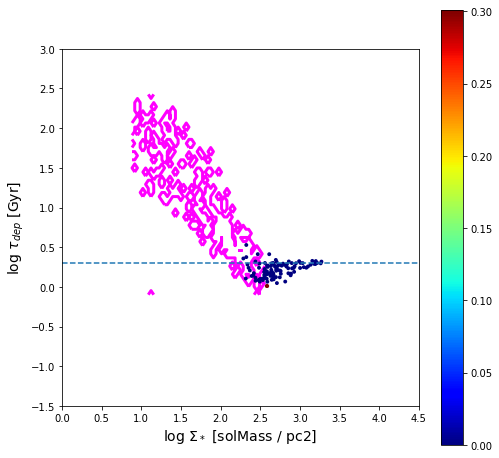

In [6]:
# Select data to plot (must be loggable)
not_nan = (~np.isnan(sig_star)) & (~np.isnan(t_dep)) & (sig_star>0) & (t_dep>0)
not_nan_ndet = (~np.isnan(sig_star_ndet)) & (~np.isnan(t_dep_ndet)) & (sig_star_ndet>0) & (t_dep_ndet>0)
print('Excluding {} invalid values'.format(len(np.nonzero(~not_nan)[0])))
print('Number of valid points:',len(np.nonzero(not_nan)[0]))

x_det, y_det, z_det, *hist = xy2hist(sig_star[not_nan], t_dep[not_nan], log=True)
x_ndet, y_ndet, z_ndet, *hist2 = xy2hist(sig_star_ndet[not_nan_ndet], 
                                         t_dep_ndet[not_nan_ndet], 
                                         log=True, bins=[50,50])
# Make the scatter plots
fig, ax = plt.subplots(figsize=(8,8))
cm = plt.cm.get_cmap('jet')
sc = ax.scatter(x_det, y_det, c=z_det, s=15, edgecolor='', cmap=cm)
ax.contour(hist2[0].transpose(),[10,30,100,300],
           extent=[hist2[1].min(),hist2[1].max(),
                   hist2[2].min(),hist2[2].max()],
           colors='magenta',linewidths=3,zorder=-1)
plt.xlabel(r'log $\Sigma_*$ ['+str(sig_star.unit)+']',fontsize=14)
plt.ylabel(r'log $\tau_{dep}$ ['+str(t_dep.unit)+']',fontsize=14)
ax.set_aspect('equal')
ax.axhline(0.3, linestyle='--')
ax.set_xlim(0,4.5)
ax.set_ylim(-1.5,3)
plt.colorbar(sc)

## Depletion time vs. local sSFR

Excluding 0 invalid values
Number of valid points: 102


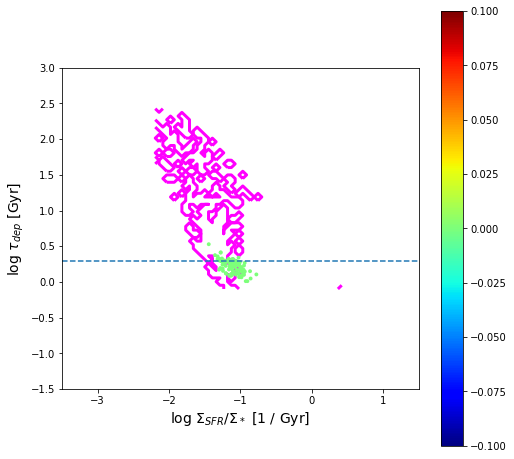

In [7]:
# Select data to plot (must be loggable)
not_nan = (np.isfinite(sig_ssfr)) & (np.isfinite(t_dep)) & (sig_ssfr>0) & (t_dep>0)
not_nan_ndet = (np.isfinite(sig_ssfr_ndet)) & (np.isfinite(t_dep_ndet)) & (sig_ssfr_ndet>0) & (t_dep_ndet>0)
print('Excluding {} invalid values'.format(len(np.nonzero(~not_nan)[0])))
print('Number of valid points:',len(np.nonzero(not_nan)[0]))

x_det, y_det, z_det, *hist = xy2hist(sig_ssfr[not_nan], t_dep[not_nan], log=True)
x_ndet, y_ndet, z_ndet, *hist2 = xy2hist(sig_ssfr_ndet[not_nan_ndet], 
                                         t_dep_ndet[not_nan_ndet], 
                                         log=True, bins=[50,50])
# Make the scatter plots
fig, ax = plt.subplots(figsize=(8,8))
cm = plt.cm.get_cmap('jet')
sc = ax.scatter(x_det, y_det, c=z_det, s=15, edgecolor='', cmap=cm)
ax.contour(hist2[0].transpose(),[10,30,100,300],
           extent=[hist2[1].min(),hist2[1].max(),
                   hist2[2].min(),hist2[2].max()],
           colors='magenta',linewidths=3,zorder=-1)
plt.xlabel(r'log $\Sigma_{SFR}$/$\Sigma_*$ ['+str(sig_ssfr.unit)+']',fontsize=14)
plt.ylabel(r'log $\tau_{dep}$ ['+str(t_dep.unit)+']',fontsize=14)
ax.set_aspect('equal')
ax.axhline(0.3, linestyle='--')
ax.set_xlim(-3.5,1.5)
ax.set_ylim(-1.5,3)
plt.colorbar(sc)